In [1]:
import numpy as np 
import tensorflow as tf 
from scipy.special import logsumexp 
import matplotlib.pyplot as plt 

from typing import List
from tqdm import tqdm 

from util import image_transform

%matplotlib inline 

In [2]:
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.mnist.load_data()

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(60000, 28, 28)
(60000,)
(10000, 28, 28)
(10000,)


In [3]:
# biến đổi ảnh về nhị phân 
binary_X_train = image_transform(X_train)
binary_X_test = image_transform(X_test)

# tách các điểm dữ liệu thuộc các lớp khác nhau ra 
def label_classify(data, labels, cls): 
    return data[labels == cls]

In [4]:
cls = []
for i in range(10): 
    cls.append(label_classify(binary_X_train, y_train, i))
    
cls = np.array(cls)
cls[0].shape

C:\Users\admin\AppData\Local\Temp\ipykernel_24412\489650966.py:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  cls = np.array(cls)


(5923, 28, 28)

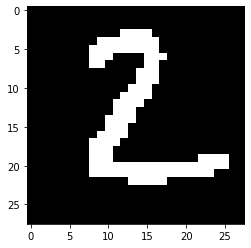

In [5]:
plt.imshow(binary_X_test[1], cmap=plt.cm.gray)

In [8]:
def show_images(imgs: List[float], num_rows, num_cols, scale=2, titles: List[int] = None):
    """Show (a list of) binary images.
    """

    figsize = (num_cols * scale, num_rows * scale)
    _, axes = plt.subplots(num_rows, num_cols, figsize=figsize)

    axes = axes.flatten()
    for i, (ax, img) in enumerate(zip(axes, imgs)): 
        ax.imshow(img, cmap=plt.cm.gray)
        ax.axes.get_xaxis().set_visible(False)
        ax.axes.get_yaxis().set_visible(False)
        
        if titles is not None: 
            ax.set_title(titles[i])
            
    plt.show()

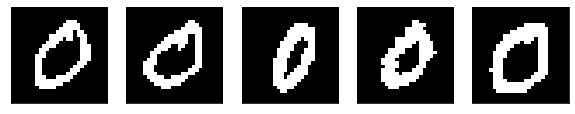

In [9]:
show_images(cls[0][:5], 1, 5)

In [134]:
class BMM: 
    """EM Algorithm for Bernoulli Mixture Model.
    """

    def __init__(self, k: int, dim: int, alpha=None, init_mu=None, init_pi=None):
        """Define a Bernoulli mixture model with known number of clusters and dimensions.

        Input: 
        - k: number of clusters 
        - dim: dimension 
        - init_theta: initial value for the probability of success 
        """
        
        self.K = k 
        self.D = dim 
        self.alpha = alpha 

        if init_mu is None: 
            init_mu = np.random.uniform(.25, .75, (k, dim))
            # init_mu /= np.sum(init_mu, axis=1, keepdims=True)
        self.mu = init_mu

        if init_pi is None: 
            init_pi = np.ones(k) / k        # uniform distribution of pi 
        self.pi = init_pi 

    def _init_em(self, X): 
        """Initialization of EM algorithm for Bernoulli mixture model.

        Input: 
        - X: data (batch_size, dim)
        """

        self.X = X                                  # data matrix 
        self.N = X.shape[0]                         # the number of data points 
        self.Z = np.zeros((self.N, self.K))         # responsibility matrix 

    def _e_step(self): 
        """E-step of EM algorithm. 
        
        Evaluate the responsibilities (Z) using the current parameter values and log-sum-exp.
        """

        for i in range(self.K): 
            self.Z[:, i] = np.log(self.pi[i]) + np.sum((self.X * np.log(self.mu[i]) + (1 - self.X) * np.log(1 - self.mu[i])), axis=1)
        
        self.Z -= logsumexp(self.Z, axis=1, keepdims=True)  
        self.Z = np.exp(self.Z)
        
    def _m_step(self): 
        """M-step of EM algorithm. 
        
        Re-estimate the parameters using the current responsibilities Z.
        """

        # update priors
        self.pi = self.Z.sum(axis=0) / self.N 

        # update mu using Laplace smoothing 
        self.mu = np.matmul(self.Z.T, self.X) 
        if self.alpha: 
            self.mu += self.alpha 
        self.mu /= (self.Z.sum(axis=0) + self.alpha * self.K)[:, np.newaxis]

    def _log_likelihood(self, X): 
        """Compute the log-likelihood of X under current parameters.

        Input: 
        - X: data (batch_size, dim)

        Output: 
        - log-likelihood of X: Sum_n log(Sum_k(pi_k * Ber(x_n | mu_k)))
        """

        ll = 0
        for x in X:
            log_margin = np.log(self.pi)[:, np.newaxis] + np.sum(x * np.log(self.mu) + (1 - x) * np.log(1 - self.mu), axis=1, keepdims=True)
            ll += logsumexp(log_margin)  
        
        return ll

    def fit(self, X, max_iter=100, tol=1e-2):
        """Fit BMM to training data.
        """

        self._init_em(X)
        ll_hist = [self._log_likelihood(X)]
        
        self._e_step()
        self._m_step()
        ll_hist.append(self._log_likelihood(X))
    
        for i in tqdm(range(max_iter)):
            if ll_hist[-1] - ll_hist[-2] > tol:
                self._e_step()
                self._m_step()
                ll_hist.append(self._log_likelihood(X))
            else: 
                print("Terminate at {}th iteration. Log-likelihood is {}".format(i + 1, ll_hist[-1]))
                plt.plot(ll_hist, marker='.')
                plt.show()
                break

In [139]:
N, k, dim, alpha, max_iter, tol = 10_000, 10, 784, 1e-1, 100, 1e-2

X = image_transform(X_train)[:N].reshape(-1, dim)
X.shape

(10000, 784)

 41%|████████████████████████████████████████████████████                                                                           | 41/100 [02:01<03:01,  3.07s/it]

Terminate at 42th iteration. Log-likelihood is -1634721.330110609


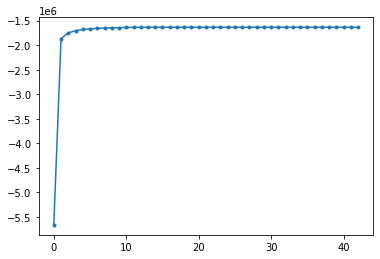

 41%|████████████████████████████████████████████████████                                                                           | 41/100 [02:02<02:55,  2.98s/it]


In [140]:
bmm = BMM(k=k, dim=dim, alpha=alpha)
bmm.fit(X, max_iter=max_iter, tol=tol)

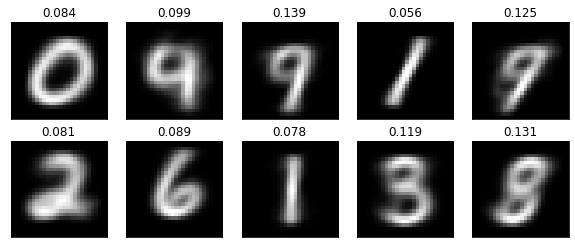

In [141]:
show_images(bmm.mu.reshape(-1, 28, 28), 2, 5, titles=np.around(bmm.pi, 3))

(1500, 28, 28)
(1500, 784)


 27%|██████████████████████████████████▎                                                                                            | 27/100 [00:05<00:13,  5.39it/s]

Terminate at 28th iteration. Log-likelihood is -275362.3455705018


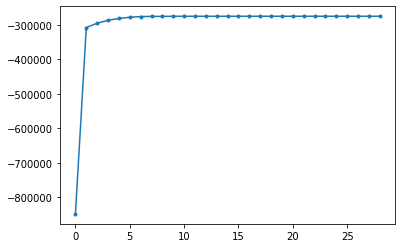

 27%|██████████████████████████████████▎                                                                                            | 27/100 [00:05<00:14,  5.21it/s]


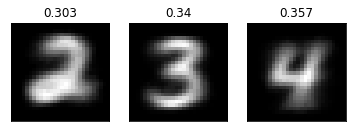

In [147]:
train_data = np.concatenate((cls[2][:500], cls[3][:500], cls[4][:500]), axis=0)
np.random.shuffle(train_data)
print(train_data.shape)

train_data = train_data.reshape(-1, 784)
print(train_data.shape)

bmm = BMM(k=3, dim=784, alpha=1e-1)
bmm.fit(train_data, max_iter=100, tol=1e-5)

show_images(bmm.mu.reshape(-1, 28, 28), 1, 3, titles=np.around(bmm.pi, 3))

 56%|███████████████████████████████████████████████████████████████████████                                                        | 56/100 [01:18<00:59,  1.36s/it]

Terminate at 57th iteration. Log-likelihood is -826479.3128232514


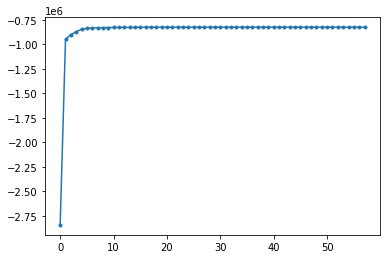

 56%|███████████████████████████████████████████████████████████████████████                                                        | 56/100 [01:19<01:02,  1.41s/it]


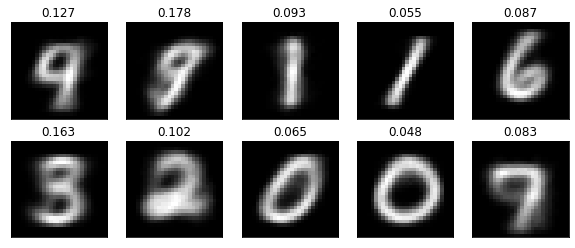

In [146]:
train_data = np.concatenate([cls[i][:500] for i in range(10)], axis=0)
np.random.shuffle(train_data)
train_data = train_data.reshape(-1, 784)
train_data.shape

bmm = BMM(k=10, dim=784, alpha=1e-1)
bmm.fit(train_data, max_iter=100, tol=1e-2)

show_images(bmm.mu.reshape(-1, 28, 28), 2, 5, titles=np.around(bmm.pi, 3))

(1500, 784)


 54%|████████████████████████████████████████████████████████████████████▌                                                          | 54/100 [00:10<00:08,  5.25it/s]

Terminate at 55th iteration. Log-likelihood is -259180.47044420484


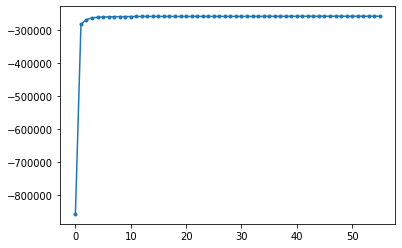

 54%|████████████████████████████████████████████████████████████████████▌                                                          | 54/100 [00:10<00:09,  5.03it/s]


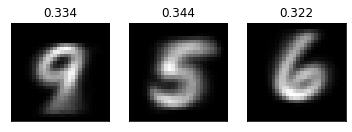

In [144]:
train_data = np.concatenate((cls[5][:500], cls[9][:500], cls[6][:500]), axis=0)
np.random.shuffle(train_data)

train_data = train_data.reshape(-1, 784)
print(train_data.shape)

bmm = BMM(k=3, dim=784, alpha=1e-1)
bmm.fit(train_data, max_iter=100, tol=1e-5)

show_images(bmm.mu.reshape(-1, 28, 28), 1, 3, titles=np.around(bmm.pi, 3))

(1200, 784)


 33%|█████████████████████████████████████████▉                                                                                     | 33/100 [00:06<00:11,  5.75it/s]

Terminate at 34th iteration. Log-likelihood is -187280.42615592523


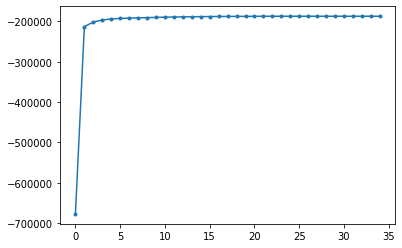

 33%|█████████████████████████████████████████▉                                                                                     | 33/100 [00:06<00:12,  5.40it/s]


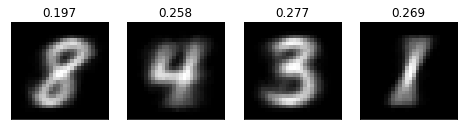

In [148]:
train_data = np.concatenate((cls[3][:300], cls[4][:300], cls[1][:300], cls[8][:300]), axis=0)
np.random.shuffle(train_data)

train_data = train_data.reshape(-1, 784)
print(train_data.shape)

bmm = BMM(k=4, dim=784, alpha=1e-1)
bmm.fit(train_data, max_iter=100, tol=1e-5)

show_images(bmm.mu.reshape(-1, 28, 28), 1, 4, titles=np.around(bmm.pi, 3))